# Mighty Pythons
## The greatest fantasy football team of all time
In this workbook I forecast how many points each player in the premier league will receive in the fantasy football game, and then seek to find the optimal team

### First, let's load all the libraries needed and some basic settings

In [1]:
### in this cell, the libraries needed are imported and the raw data files are loaded as a panda dataframe
import time

start_time = time.time() #start a timer

import numpy as np
import pandas as pd
import itertools
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 7, 7

from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

### Now, define who is in the team I initially have at the start of the week, and the total budget I have for players

In [2]:
###Budget is established
Budget = 98.8 #define budget

## set the current team
current_team_names = ['KEPA, GLK','HART, GLK',
                    'AZPILICUETA, DEF','TRIPPIER, DEF','BENNETT, DEF','KEANE, DEF','YEDLIN, DEF',
                    'NEVES, MID','STERLING, MID','BILLING, MID','RICHARLISON, MID','SERI, MID',
                   'KANE, FWD','AUBAMEYANG, FWD','MOUNIE, FWD']

### Now load in the data I have on players and pre-process it for use in machine learning

In [3]:
%%time
# load the data to be used for training the regressor
full_data=pd.read_excel('trainer_v2.xlsx')


#drop week 0-3 as it is basically a whole season and makes impossible to divide by number of weeks and messes with historic points
full_data = full_data[(full_data.Week>=3)]
full_data.reindex()
full_data=full_data.reset_index(drop=True)

### in this cell, historical data is used to train a random forest regression to predict future points

# calculate net transfers, set cost in millions, drop unused columns
full_data['NetTransfers']=(full_data.TransfersInRound-full_data.TransfersOutRound)
full_data['Cost']=(full_data.Cost/1000000)
full_data['Value']=full_data['Cost']


#copy of team and position names
supp_data = pd.DataFrame()
supp_data['OriginalTeam'] = full_data['Team']

# turn team into dummy variables
full_data = pd.get_dummies(full_data, columns = ['Team'], prefix=['Team'],drop_first=True)

# #normalise various fields by week number
full_data['YellowCards_perWeek'] = (full_data.YellowCards /  full_data.Week)
full_data['GoalsConceded_perWeek'] = (full_data.GoalsConceded /  full_data.Week)
full_data['Saves_perWeek'] = (full_data.Saves /  full_data.Week)
full_data['GoalsScored_perWeek'] = (full_data.GoalsScored /  full_data.Week)
full_data['Bonus_perWeek'] = (full_data.Bonus /  full_data.Week)
full_data['CleanSheets_perWeek'] = (full_data.CleanSheets /  full_data.Week)
full_data['Assists_perWeek'] = (full_data.Assists /  full_data.Week)
full_data['PenaltiesSaved_perWeek'] = (full_data.PenaltiesSaved /  full_data.Week)
full_data['MinutesPlayed_perWeek'] = (full_data.MinutesPlayed /  full_data.Week)

# drop unnecessary fields
full_data = full_data.drop(labels=['FirstName', 'TotalPoints',  'AveragePointsPerDollar', 'TotalPointsPerDollar', 'GoalsConcededPoints',
                         'SavesPoints', 'GoalsScoredPoints', 'ValueSeason', 'TransfersOut', 'PriceRise', 'PriceFallRound',
                         'PriceFall', 'ValueForm', 'PenaltiesMissed', 'CleanSheetPoints', 'TransfersIn', 'OwnGoals', 
                         'DreamteamCount', 'PriceRiseRound', 'RedCards', 'BPS', 'Cost','TransfersInRound',
                         'TransfersOutRound','NextFixture1','NextFixture2','NextFixture3',
                         'NextFixture4','NextFixture5','YellowCards','GoalsConceded','Saves',
                         'GoalsScored','Bonus','CleanSheets','Assists','PenaltiesSaved','MinutesPlayed','Season'],axis =1)

# move future points to end of the dataframe
#original version where just using literal future points
full_data['Future Points']=full_data['points over next 4 weeks']

# #alternative version where take the log of the future points and drop NAs and infinite values (negative future points)
# full_data['Future Points']=full_data['points over next 4 weeks'].apply(lambda x: np.log(x)).replace([np.inf, -np.inf], np.nan).dropna()
# full_data = full_data.drop(labels=['points over next 4 weeks'],axis =1)
# full_data['Future Points'].dropna(inplace=True)

# save column names to reform dataframe later and count number of independent variables
col_names = full_data.iloc[:, 5:].columns.tolist()
X_width = len(col_names)
#col_names

Wall time: 36.6 s


In [4]:
full_data[full_data.Functional_week==full_data.Functional_week.max()-8]

,Week,Functional_week,Full Name,Surname,PositionsList,PointsLastRound,AveragePoints,GameweekWeighting,LastSeasonPoints,Form,...,YellowCards_perWeek,GoalsConceded_perWeek,Saves_perWeek,GoalsScored_perWeek,Bonus_perWeek,CleanSheets_perWeek,Assists_perWeek,PenaltiesSaved_perWeek,MinutesPlayed_perWeek,Future Points
42699,4,80,"ABRAHAM, FWD",Abraham,FWD,0,0.000000,0,0,0.0,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0
42700,4,80,"ADAM SMITH, DEF",Adam Smith,DEF,-2,2.000000,0,6,2.0,...,0.00,0.75,0.0,0.00,0.00,0.25,0.00,0.0,60.00,18
42701,4,80,"ADRIAN, GLK",Adrian,GLK,0,0.000000,0,0,0.0,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0
42702,4,80,"AGUERO, FWD",Aguero,FWD,2,8.000000,0,24,8.0,...,0.00,0.50,0.0,0.75,0.75,0.25,0.25,0.0,60.75,28
42703,4,80,"AKE, DEF",Ake,DEF,8,6.000000,0,18,6.0,...,0.00,0.75,0.0,0.25,0.75,0.25,0.00,0.0,67.50,10
42704,4,80,"ALBRIGHTON, MID",Albrighton,MID,4,1.666667,0,5,1.7,...,0.00,0.00,0.0,0.00,0.00,0.00,0.25,0.0,20.50,11
42705,4,80,"ALDERWEIRELD, DEF",Alderweireld,DEF,6,4.000000,0,8,2.7,...,0.00,0.25,0.0,0.00,0.00,0.25,0.00,0.0,45.00,15
42706,4,80,"ALEXANDER-ARNOLD, DEF",Alexander-Arnold,DEF,5,5.000000,0,15,5.0,...,0.75,0.00,0.0,0.00,0.00,0.75,0.00,0.0,67.00,21
42707,4,80,"ALISSON, GLK",Alisson,GLK,6,6.300000,0,19,6.3,...,0.00,0.00,1.5,0.00,0.25,0.75,0.00,0.0,67.50,20
42708,4,80,"ALLI, MID",Alli,MID,3,5.700000,0,17,5.7,...,0.00,0.50,0.0,0.25,0.50,0.25,0.25,0.0,64.75,3


## using a random forest
### use a random forest regressor on each of the positions to predict future score

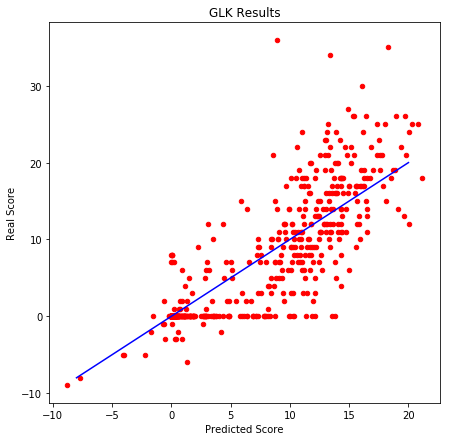

GLK Out of Sample 0.648485520179
CV score = 0.75108405583


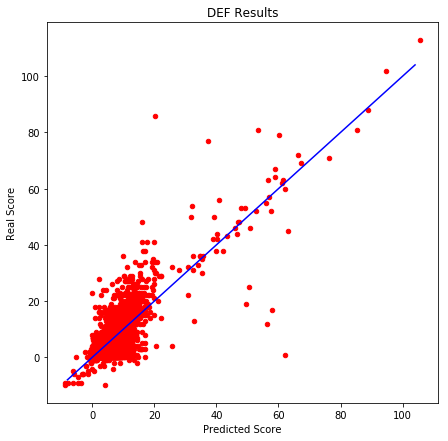

DEF Out of Sample 0.59739745174
CV score = 0.758554102768


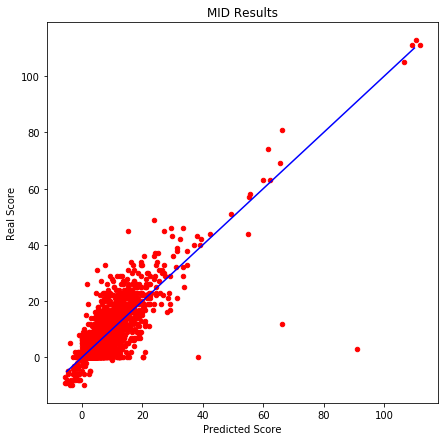

MID Out of Sample 0.654823449077
CV score = 0.7307361697


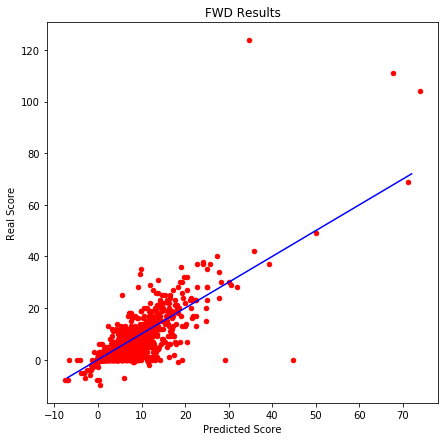

FWD Out of Sample 0.441159518546
CV score = 0.662091019235
Wall time: 9min 53s


In [5]:
%%time
## setting up the non-scaled variables and set up training/test split for non-scaled data for Random Forest etc.

#strip out weeks with no future points
Weeklist = list(range(full_data['Functional_week'].max() -4))

#dataframe where the future points are at least -10 to remove the weeks where we basically have no data
# full_data_for_regression = full_data[full_data['Future Points']>= -10]

positions = ['GLK','DEF','MID','FWD']
RF_pred = pd.DataFrame(columns=['Full Name','RF Prediction'])

#define columns that will be needed for the regression
RF_regression_x_cols = ['PointsLastRound', 'AveragePoints', 'GameweekWeighting',
       'LastSeasonPoints', 'Form', 'FanRating', 'SelectedByPercent', 'EAIndex',
       'Points_prev4weeks', 'Saves_prev4weeks', 'GoalsScored_prev4weeks',
       'Bonus_prev4weeks', 'Assists_prev4weeks', 'MinutesPlayed_prev4weeks',
       'NetTransfers', 'Value', 'Team_BHA', 'Team_BOU', 'Team_BUR', 'Team_CHE',
       'Team_CRY', 'Team_EVE', 'Team_HUD', 'Team_HUL', 'Team_LEI', 'Team_LIV',
       'Team_MCI', 'Team_MID', 'Team_MUN', 'Team_NEW', 'Team_SOU', 'Team_STK',
       'Team_SUN', 'Team_SWA', 'Team_TOT', 'Team_WAT', 'Team_WBA', 'Team_WHU',
       'YellowCards_perWeek', 'GoalsConceded_perWeek', 'Saves_perWeek',
       'GoalsScored_perWeek', 'Bonus_perWeek', 'CleanSheets_perWeek',
       'Assists_perWeek', 'PenaltiesSaved_perWeek', 'MinutesPlayed_perWeek']

#loop through positions and do a RF refression on each
for i in range (4):
    z = positions[i] #choose a position from the list
    #set up a dataframe for just this position and just those players who got at least -10 points over next 4 weeks
    z_full_data= full_data[(full_data.PositionsList==str(z))&(full_data['Future Points']>=-10)]

    # set up matrices for goalies
    X = z_full_data[(z_full_data.Functional_week.isin(Weeklist))].loc[:,RF_regression_x_cols].values
    np.nan_to_num(X,copy=False) #get rid of this after week 1 is done
    y = z_full_data[(z_full_data.Functional_week.isin(Weeklist))].loc[:, 'Future Points'].values

    # Splitting the dataset into the Training set and Test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

    # Fitting the random forest  model to the dataset

    RF_regressor = RandomForestRegressor(n_estimators =5)
    RF_regressor.fit(X_train,y_train)

    # Applying Grid Search to find the best model and the best parameters

    #define parameters- note these are then used in all the positions
    parameters = [{'bootstrap': ['FALSE'], 'max_depth': [10,20], 
                  'max_features': ['auto'], 'min_samples_leaf': [1,5,10], 
                  'n_estimators': [10,20,50], 'oob_score': ['TRUE']}]
    grid_search = GridSearchCV(estimator = RF_regressor,
                               param_grid = parameters,
                               scoring = 'r2',
                               cv = 5)
    grid_search = grid_search.fit(X_train, y_train)

    #set the random forest regressor as best result of grid search
    RF_regressor = grid_search.best_estimator_

    #predict the results
    y_pred = RF_regressor.predict(X_test)

    plt.scatter(y_pred, y_test, color = 'red',s=20)
    plt.title(str(z)+' Results')
    plt.xlabel('Predicted Score')
    plt.ylabel('Real Score')
    plt.plot(range(int(y_pred.min()),int(y_pred.max())),range(int(y_pred.min()),int(y_pred.max())),color = 'blue')
    plt.show() 
    
    #print the r2 result
    RF_r2 = r2_score(y_pred, y_test)
    print(str(z)+' Out of Sample ' + str(RF_r2))
    print('CV score = ' + str(grid_search.best_score_))

    #set the current week data as a new dataframe- note used full data rather than zfulldata to make sure get full player list
    z_full_data = full_data[(full_data.PositionsList==str(z))&(full_data.Functional_week==full_data['Functional_week'].max())]

    #import it as an array and use the fitted regressor
    X = z_full_data.loc[:, RF_regression_x_cols].values
    np.nan_to_num(X,copy=False) #get rid of this after week 1 is done

    #predict the scores of current week
    y_pred_full = RF_regressor.predict(X)
    
    #save the predicted score in a dataframe
    RF_pred = RF_pred.append(pd.DataFrame((np.concatenate(
    ([[z_full_data['Full Name'].values],[y_pred_full]]),axis=0,
    ).transpose()),columns=['Full Name','RF Prediction']))
    

In [6]:
#bring back the team names!
full_data['Team']= supp_data['OriginalTeam'] 

#define the players in the current week as a new dataframe
current_week = full_data[(full_data.Functional_week==full_data['Functional_week'].max())]

#bring in a way to sort by positions
current_week['Pos_rank']= current_week['PositionsList'].replace({'GLK':0, 'DEF':1, 'MID':2, 'FWD':3})

#then sort by positions and then name
current_week.sort_values(['Pos_rank', 'Full Name'], ascending=[True, True],inplace=True)

#reset the index
current_week.reset_index(inplace=True)

#bring in the RF predicted points
current_week['Future Points'] = RF_pred['RF Prediction'].values

## Now use the predicted scores to build the mighty pythons!

In [7]:
# combine players back into 1 dataframe
one_switch = current_week[['Full Name','PositionsList','Team','Future Points','Value']]

# declares current team

one_switch['InCurrentTeam']=0
one_switch.set_value(one_switch['Full Name'].isin(current_team_names),'InCurrentTeam',1)
one_switch.reset_index(drop=True, inplace=True)
one_switch[(one_switch.InCurrentTeam==1)]

,Full Name,PositionsList,Team,Future Points,Value,InCurrentTeam
28,"HART, GLK",GLK,BUR,12.7702,4.5,1
33,"KEPA, GLK",GLK,CHE,12.1254,5.5,1
65,"AZPILICUETA, DEF",DEF,CHE,17.0358,6.3,1
77,"BENNETT, DEF",DEF,WOL,8.73377,4.2,1
145,"KEANE, DEF",DEF,EVE,9.93486,4.9,1
231,"TRIPPIER, DEF",DEF,TOT,12.0267,6.2,1
245,"YEDLIN, DEF",DEF,NEW,9.71347,4.5,1
270,"BILLING, MID",MID,HUD,9.64646,4.5,1
405,"NEVES, MID",MID,WOL,9.26822,5.0,1
426,"RICHARLISON, MID",MID,EVE,11.1618,6.9,1


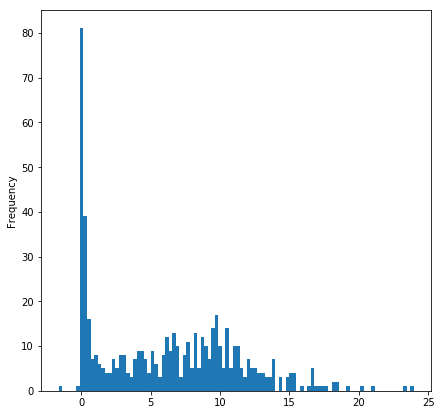

In [8]:
one_switch['Future Points'].plot(kind='hist',bins=100)

## Work out the best 1 transfer from the current team

In [9]:
%%time

#works out how much spare cash there is for transfers
sparecash = Budget - one_switch[(one_switch.InCurrentTeam==1)].Value.sum()

# works out team which is most highly picked in existing team to avoid going over the 3 players per team cap
most_picked_team = one_switch[(one_switch.InCurrentTeam==1)]['Team'].value_counts().idxmax()
most_picked_team_count = one_switch[(one_switch.InCurrentTeam==1)]['Team'].value_counts().max()

#work out points pick up from every plausible single transfer
for j in range(1,16):
    #add a column relating to point pick up in replacing jth player in the existing team
    one_switch[str('switch_player_'+str(j))]=0
    
    # loop through every player in current game week
    for i in range(len(one_switch)):
        
        #check if ith player is same position as jth, note need to use j-1 so tags tie up properly
        if one_switch['PositionsList'].iloc[i] == one_switch[(one_switch.InCurrentTeam==1)]['PositionsList'].iloc[j-1]:
            
            #check if there is sufficient budget to buy the player
            if one_switch['Value'].iloc[i] <= (one_switch[(one_switch.InCurrentTeam==1)]['Value'].iloc[j-1] + sparecash):
                
                #check if the 3 players from each team rule is violated
                if one_switch['Team'].iloc[i] == most_picked_team:
                    if most_picked_team_count <=2:
                       
                        #if ok from all these filters then return the pickup in prediction
                        one_switch[str('switch_player_'+str(j))].iloc[i] = one_switch['Future Points'].iloc[i] - one_switch[(one_switch.InCurrentTeam==1)]['Future Points'].iloc[j-1]
                                               
                elif most_picked_team_count <=3:
                    #if ok from all these filters then return the pickup in prediction
                    one_switch[str('switch_player_'+str(j))].iloc[i] = one_switch['Future Points'].iloc[i] - one_switch[(one_switch.InCurrentTeam==1)]['Future Points'].iloc[j-1] 
                                        
# record max potential pick up from each potential transfer
pickup =[]
for i in range (6,len(one_switch.columns)):
    pickup.append(one_switch.iloc[:,i].max())

#get which player number should be switched out
pickup.index(max(pickup))

# get name of player to be switched out
print('player out: '+one_switch[(one_switch.InCurrentTeam==1)]['Full Name'].iloc[pickup.index(max(pickup))])

# get name of player to be switched in
print('player in: '+one_switch.iloc[one_switch.iloc[:,(6+pickup.index(max(pickup)))].idxmax()]['Full Name'])

# give max available pickup
print('pickup available: '+str(max(pickup)))

player out: NEVES, MID
player in: HAYDEN, MID
pickup available: 11.8017763087
Wall time: 3min 14s


In [10]:
print(str(round((time.time() - start_time)/60))+' minutes')

14 minutes


## copy pasted- wildcard generating team

In [11]:
#define the position lists
current_week.sort_values(['Future Points'], ascending=False,inplace=True)

Goalies = current_week[(current_week.PositionsList=='GLK')]
Defenders = current_week[(current_week.PositionsList=='DEF')]
Midfielders = current_week[(current_week.PositionsList=='MID')]
Strikers = current_week[(current_week.PositionsList=='FWD')]

#take top 20 in each position
Goalies = Goalies[:20]
Defenders = Defenders[:20]
Midfielders = Midfielders[:20]
Strikers = Strikers[:20]

#combining the player lists
PlayerList = [Goalies, Defenders, Midfielders, Strikers]
data = pd.concat(PlayerList)

#adding new columns
data['InTrialTeam']=0
data['InFixTeam']=0
data['InMaxTeam']=0
data['InCurrentTeam']=0
data.set_value(one_switch['Full Name'].isin(current_team_names),'InCurrentTeam',1)

#redefine and index data
data.reindex()
data=data.reset_index(drop=True)

In [12]:
### in this cell, the max team is found and fix/trial team characteristics are defined

#define the characteristics of the max points team

data.set_value([0,1,20,21,22,23,24,40,41,42,43,44,60,61,62],'InMaxTeam',1)

MaxTeam=data[(data.InMaxTeam==1)]
MaxTeamValue= MaxTeam.Value.sum()
MaxTeamScore = MaxTeam['Future Points'].sum()
MaxTeamPlayers = len(MaxTeam)

#define the characteristics of the fixed team, initially blank

FixTeam=data[(data.InFixTeam==1)]
FixTeamValue= FixTeam.Value.sum()
FixTeamScore = FixTeam['Future Points'].sum()
FixTeamPlayers = len(FixTeam)

#define the characteristics of the trial team, initially blank

TrialTeam = data[(data.InTrialTeam==1)]
TrialTeamValue= TrialTeam.Value.sum()
TrialTeamScore = TrialTeam['Future Points'].sum()
TrialTeamPlayers = len(TrialTeam)

#works out the max budget to be used later in iterations
MaxGolBudg = int(np.ceil(MaxTeam[(MaxTeam.PositionsList== 'GLK')].Value.sum())+1)
MaxDefBudg = int(np.ceil(MaxTeam[(MaxTeam.PositionsList== 'DEF')].Value.sum())+1)
MaxMidBudg = int(np.ceil(MaxTeam[(MaxTeam.PositionsList== 'MID')].Value.sum())+1)
MaxStrBudg = int(np.ceil(MaxTeam[(MaxTeam.PositionsList== 'FWD')].Value.sum())+1)

print (MaxTeamValue, MaxTeamScore)
MaxTeam[['Full Name','PositionsList','Team','Value','Future Points','InMaxTeam','InCurrentTeam']]

114.10000000000002 274.8893671387466


,Full Name,PositionsList,Team,Value,Future Points,InMaxTeam,InCurrentTeam
0,"EDERSON, GLK",GLK,MCI,5.8,18.208,1,0
1,"DE GEA, GLK",GLK,MUN,5.8,15.4342,1,0
20,"RUDIGER, DEF",DEF,CHE,6.0,17.2776,1,0
21,"AZPILICUETA, DEF",DEF,CHE,6.3,17.0358,1,1
22,"HOLGATE, DEF",DEF,EVE,4.4,15.4805,1,0
23,"DAVID LUIZ, DEF",DEF,CHE,5.6,15.2203,1,0
24,"TAYLOR, DEF",DEF,BUR,4.4,13.6258,1,0
40,"SALAH, MID",MID,LIV,13.0,23.3,1,0
41,"HAYDEN, MID",MID,NEW,4.4,21.07,1,0
42,"MURPHY, MID",MID,NEW,4.8,19.1758,1,0


In [13]:
### in this cell, functions to get best sub-team for a position and given budget are created

def BestGoalies(Budget,Gtop): #function which picks the best goalies for given budget
    data['InTrialTeam']=0
    data['InFixTeam']=0
    for G1 in range (0,Gtop-1):
        for G2 in range (G1+1,Gtop):
            data['InTrialTeam']=0
            data.set_value([G1,G2],'InTrialTeam',1)
            TrialTeam = data[(data.InTrialTeam==1)]
            TrialTeamScore = TrialTeam['Future Points'].sum() - 0.5*TrialTeam['Future Points'].min()
            FixTeam=data[(data.InFixTeam==1)]
            if np.isnan(FixTeam['Future Points'].sum() -0.5* FixTeam['Future Points'].min()):
                FixTeamScore = 0
            else: FixTeamScore = (FixTeam['Future Points'].sum() -0.5* FixTeam['Future Points'].min())
            ClubCount = max(TrialTeam.Team.value_counts()) # returns max number of player from any one club
            #halve score from sub-goalie as they never play
            if ClubCount <2 and TrialTeamScore > FixTeamScore and TrialTeam.Value.sum() <= Budget:
                data['InFixTeam']=0
                data.set_value([G1,G2],'InFixTeam',1)
                FixTeam=data[(data.InFixTeam==1)]
    return FixTeam
    
def BestDefence(Budget,Dtop): #function which picks the best defence for given budget
    data['InTrialTeam']=0
    data['InFixTeam']=0
    for D1 in range (20,Dtop-4):
        for D2 in range (D1+1,Dtop-3):
            for D3 in range (D2+1,Dtop-2):
                for D4 in range (D3+1,Dtop-1):
                    for D5 in range (D4+1,Dtop):
                        data['InTrialTeam']=0
                        data.set_value([D1,D2,D3,D4,D5],'InTrialTeam',1)
                        TrialTeam = data[(data.InTrialTeam==1)]
                        FixTeam=data[(data.InFixTeam==1)]
                        ClubCount = max(TrialTeam.Team.value_counts()) # returns max number of player from any one club
                        if ClubCount <2 and TrialTeam['Future Points'].sum() > FixTeam['Future Points'].sum() and TrialTeam.Value.sum() <= Budget:
                            data['InFixTeam']=0
                            data.set_value([D1,D2,D3,D4,D5],'InFixTeam',1)
                            FixTeam=data[(data.InFixTeam==1)]
    return FixTeam    


def BestMidfield(Budget,Mtop): #function which picks the best midfield for given budget
    data['InTrialTeam']=0
    data['InFixTeam']=0
    for M1 in range (40,Mtop-4):
        for M2 in range (M1+1,Mtop-3):
            for M3 in range (M2+1,Mtop-2):
                for M4 in range (M3+1,Mtop-1):
                    for M5 in range (M4+1,Mtop):
                        data['InTrialTeam']=0
                        data.set_value([M1,M2,M3,M4,M5],'InTrialTeam',1)
                        TrialTeam = data[(data.InTrialTeam==1)]
                        FixTeam=data[(data.InFixTeam==1)]
                        ClubCount = max(TrialTeam.Team.value_counts()) # returns max number of player from any one club
                        if ClubCount <2 and TrialTeam['Future Points'].sum() > FixTeam['Future Points'].sum() and TrialTeam.Value.sum() <= Budget:
                            data['InFixTeam']=0
                            data.set_value([M1,M2,M3,M4,M5],'InFixTeam',1)
                            FixTeam=data[(data.InFixTeam==1)]
    return FixTeam    

def BestStrikers(Budget,Stop): #function which picks the best strikers for given budget
    data['InTrialTeam']=0
    data['InFixTeam']=0
    for S1 in range (60,Stop-2):
        for S2 in range (S1+1,Stop-1):
            for S3 in range (S2+1,Stop):
                data['InTrialTeam']=0
                data.set_value([S1,S2,S3],'InTrialTeam',1)
                TrialTeam = data[(data.InTrialTeam==1)]
                FixTeam=data[(data.InFixTeam==1)]
                if np.isnan(FixTeam['Future Points'].sum() +FixTeam['Future Points'].max()):
                    FixTeamScore = 0
                else: FixTeamScore = (FixTeam['Future Points'].sum() + FixTeam['Future Points'].max())
                TrialTeamScore = TrialTeam['Future Points'].sum() + TrialTeam['Future Points'].max()
                ClubCount = max(TrialTeam.Team.value_counts()) # returns max number of player from any one club
                #doubles points of top FWD to account for captaincy
                if ClubCount <2 and TrialTeamScore > FixTeamScore and TrialTeam.Value.sum() <= Budget:
                    data['InFixTeam']=0
                    data.set_value([S1,S2,S3],'InFixTeam',1)
                    FixTeam=data[(data.InFixTeam==1)]
    return FixTeam    


def BestTeam(Gbudg,Dbudg,Mbudg,Sbudg): #function which combines the best position selections for their given budgets
    G = BestGoalies(Gbudg,20)
    goalies = np.array(G.Surname.unique())

    D=BestDefence(Dbudg,40)
    defence= np.array(D.Surname.unique())

    M=BestMidfield(Mbudg,60)
    midfield = np.array(M.Surname.unique())

    S=BestStrikers(Sbudg,80)
    strikers = np.array(S.Surname.unique())

    trial = itertools.chain(goalies,defence,midfield,strikers) #links together the seperate player lists into 1 list
    team=list(trial) #creates the list
    x= data[data.Surname.isin(team)] #sets that as the team
    return x

In [14]:
### this will identify best possible score at given range of budgets for each position- takes like 30 minutes though
GolPosLister = pd.DataFrame(columns=('pos','cost','score')) #set up blank dataframe for results
DefPosLister = pd.DataFrame(columns=('pos','cost','score')) #set up blank dataframe for results
MidPosLister = pd.DataFrame(columns=('pos','cost','score')) #set up blank dataframe for results
StrPosLister = pd.DataFrame(columns=('pos','cost','score')) #set up blank dataframe for results

#define range of budgets
GolRange = range(8,MaxGolBudg)
DefRange = range(20,MaxDefBudg)
MidRange = range(20,MaxMidBudg)
StrRange = range(12,MaxStrBudg)

#range of outcomes for goalies
j=0 #index for the dataframe
for i in GolRange:
    x = BestGoalies(i,20)
    y= x['Future Points'].sum() - (0.5*x['Future Points'].min()) #take away half of sub goalie points because they never play
    GolPosLister.loc[j]=('g',i,y)
    j += 1

#range of outcomes for defence
j=0 #index for the dataframe
for i in DefRange:
    x = BestDefence(i,40)
    y= x['Future Points'].sum()
    DefPosLister.loc[j]=('d',i,y)
    j += 1

#range for midfield
j=0 #index for the dataframe
for i in MidRange:
    x = BestMidfield(i,60)
    y= x['Future Points'].sum()
    MidPosLister.loc[j]=('m',i,y)
    j += 1             
    
#range of outcomes for strikers
j=0 #index for the dataframe
for i in StrRange:
    x = BestStrikers(i,80)
    y= x['Future Points'].sum() + x['Future Points'].max() #add on top player points- assume best FWD is captain
    StrPosLister.loc[j]=('s',i,y)
    j += 1

In [15]:
BudgetOptimiser = pd.DataFrame(columns=('Gol budget','Def budget', 'Mid budget','Str budget','Score'))
j=0
for i_g in range(len(GolRange)):
    for i_d in range (len(DefRange)):
        for i_m in range(len(MidRange)):
            for i_s in range(len(StrRange)):
                g_c= GolPosLister['cost'].values[i_g]
                g_s= GolPosLister['score'].values[i_g]
                d_c= DefPosLister['cost'].values[i_d]
                d_s= DefPosLister['score'].values[i_d]
                m_c= MidPosLister['cost'].values[i_m]
                m_s= MidPosLister['score'].values[i_m]              
                s_c= StrPosLister['cost'].values[i_s]
                s_s= StrPosLister['score'].values[i_s]
                if g_c + d_c + m_c+ s_c <= Budget:
                    t_s = g_s +d_s + m_s + s_s
                else:
                    s_t =0
                BudgetOptimiser.loc[j]=(g_c,d_c,m_c,s_c,t_s)
                j +=1

In [16]:
#work out what budget to consider as the maximum for each position
MaxRow= BudgetOptimiser['Score'].idxmax()
Gol_max = BudgetOptimiser['Gol budget'].values[MaxRow]
Def_max = BudgetOptimiser['Def budget'].values[MaxRow]
Mid_max = BudgetOptimiser['Mid budget'].values[MaxRow]
Str_max = BudgetOptimiser['Str budget'].values[MaxRow]

In [17]:
#this cell builds the best team based on a given budget in each position

WildCardTeam=BestTeam(Gol_max,Def_max,Mid_max,Str_max)
print('Wild Card Team costs:',round(WildCardTeam.Value.sum(),1),'Wild Card Team score is: ',round(WildCardTeam['Future Points'].sum(),2),'max players from 1 team: ',max(WildCardTeam.Team.value_counts()))
print('Max Team costs:',round(MaxTeam.Value.sum(),1),'Max Team score is: ',round(MaxTeam['Future Points'].sum(),2),'max players from 1 team: ',max(MaxTeam.Team.value_counts()))
print(round((time.time() - start_time)/60,1),' minutes') #print how long it took
WildCardTeam[['Full Name','PositionsList','Team','Value','Future Points','InMaxTeam','InCurrentTeam']]

Wild Card Team costs: 97.0 Wild Card Team score is:  252.62 max players from 1 team:  2
Max Team costs: 114.1 Max Team score is:  274.89 max players from 1 team:  3
50.8  minutes


,Full Name,PositionsList,Team,Value,Future Points,InMaxTeam,InCurrentTeam
0,"EDERSON, GLK",GLK,MCI,5.8,18.208,1,0
1,"DE GEA, GLK",GLK,MUN,5.8,15.4342,1,0
20,"RUDIGER, DEF",DEF,CHE,6.0,17.2776,1,0
22,"HOLGATE, DEF",DEF,EVE,4.4,15.4805,1,0
24,"TAYLOR, DEF",DEF,BUR,4.4,13.6258,1,0
25,"DAVIES, DEF",DEF,TOT,5.6,13.6111,0,0
28,"MUSTAFI, DEF",DEF,ARS,5.4,13.0691,0,0
41,"HAYDEN, MID",MID,NEW,4.4,21.07,1,0
46,"POGBA, MID",MID,MUN,8.0,16.734,0,0
47,"SHAQIRI, MID",MID,LIV,7.0,16.6646,0,0
